## EP20BTECH11015 - ASSIGNMENT 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy import ndimage
from scipy import optimize as opt
import pandas as pd
import emcee
import corner
from scipy.stats import gaussian_kde

1. 

In 1919, two expeditions sailed from Britain to test if the light deflection
from stars agrees with Einstein’s General Theory of Relativity. 

Einstein’s theory predicts a value of 1.74 arc-seconds, whereas Newtonian gravity
predicts a value exactly half of that. 

The team by Eddington obtained a
value of 1.61 ± 0.40 arc-seconds, while the team by Crommelin reported a

value of 1.98 ± 0.16 arc-seconds. Calculate the Bayes factor between General Relativity and Newtonian gravity from those data, assuming Gaussian likelihoods. (10 points)

(For more information about these expeditions and associated controver-
sies, check out arXiv:0709.0685)

In [2]:
gen_rel = 1.74
newton = gen_rel/2

#ASSUME GAUSSIAN LIKELIHOODS
gr_edd_pdf = st.norm(gen_rel, 0.4).pdf(1.61)

gr_cro_pdf = st.norm(gen_rel, 0.16).pdf(1.95)

ng_edd_pdf = st.norm(newton, 0.4).pdf(1.61)

ng_cro_pdf = st.norm(newton, 0.16).pdf(1.95)


bf = (gr_edd_pdf*gr_cro_pdf)/(ng_cro_pdf*ng_edd_pdf)

print("Bayes Factor for General Relativity and Classical gravity is", bf)



Bayes Factor for General Relativity and Classical gravity is 17376062454.704906


$\implies$ General Relativity is more preferable than Newtonian gravity.

2.
For exercise 1 in arXiv:1008.4686, calculate the 68% and 95% joint confidence intervals on b and m.

(Hint : Either use emcee followed by plot mcmc code in astroML.plotting
or use the corner module. 

Alternately, use the techniques of linear algebra
and using the example shown in class during the discussion on frequentist
analysis) (20 points)

In [3]:
data = pd.read_csv('table1.txt', sep='\s+')
x = data['x']
y = data['y']
yerr = data['σy']
xerr = data['σx']
rho_xy = data['ρxy']

In [4]:
def log_prior(theta):
    b, m,  f = theta

    if f < 0:
        return -np.inf


    else:
        return -1.5 * np.log(1 + m ** 2) - np.log(f)


def log_likelihood(theta, x, y, yerr):

    b, m, f = theta

    y_model = m*x + b

    return -0.5 * np.sum(np.log(2 * np.pi * yerr ** 2) + (y - y_model) ** 2 / yerr ** 2)





def log_posterior(theta, x, y, yerr):
    return log_prior(theta) + log_likelihood(theta, x, y, yerr)


ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
Nsamples = 500  # number of MCMC samples to draw
nburn = 500  # "burn-in" period to let chains stabilize
nsteps = 1000  # number of MCMC steps to take


In [5]:
Nens = 20   # number of ensemble points

m_mu = 0.     # mean of the Gaussian prior
m_sigma = 10. # standard deviation of the Gaussian prior

m_init = np.random.normal(m_mu, m_sigma, Nens) # initial m points

b_min = -10.  # lower range of prior
b_max = 10.   # upper range of prior

b_init = np.random.uniform(b_min, b_max, Nens) # initial c points

logf_min = -10.  # lower range of prior
logf_max = 10.   # upper range of prior

logf_init = np.random.uniform(logf_min, logf_max, Nens) # initial c points

init_samples = np.array([m_init, b_init, logf_init]).T # initial samples

ndims = init_samples.shape[1] # number of parameters/dimensions


Nburnin = 500   # number of burn-in samples
Nsamples = 500  # number of final posterior samples


sampler = emcee.EnsembleSampler(Nens, ndims, log_posterior, args=(x, y, yerr))
sampler.run_mcmc(init_samples, nsteps)

# extract the samples (removing the burn-in)
samples_emcee = sampler.get_chain(flat=True, discard=Nburnin)

/home/darkwake/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [6]:
m0 = samples_emcee[:,0].mean()
b0 = samples_emcee[:,1].mean()
logf0 = samples_emcee[:,2].mean()

In [7]:
def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    if "truths" not in kwargs:
        kwargs["truths"] = [m0, b0, logf0]

    fig = corner.corner(samples, labels=[r'$m$', r'$b$', r'$\log f$'], hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')

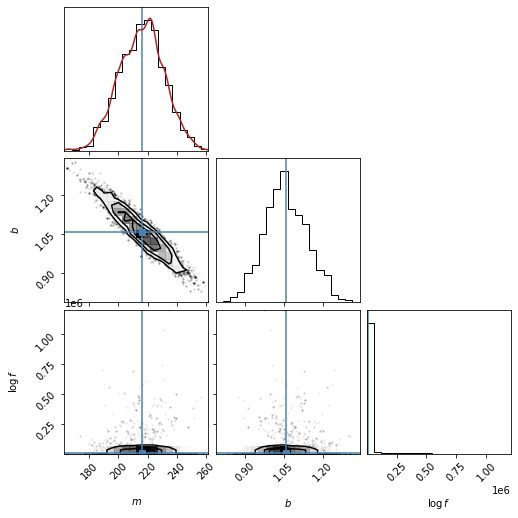

In [8]:
plotposts(samples_emcee)

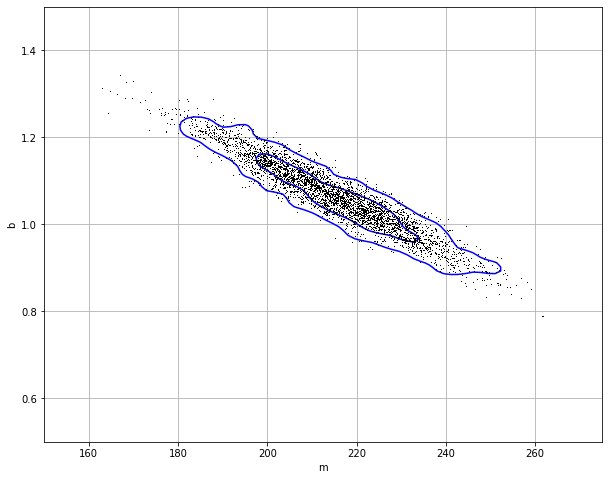

In [9]:
#USING MATPITKIN FOR M vs B only
def sigma_level(sample, nbins=20, smoothing=3):
    L, xbins, ybins = np.histogram2d(sample[0], sample[1], nbins)
    L[L == 0] = 1e-16
    logL = np.log(L)
    shape = L.shape
    L = L.ravel()
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)
    
    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    sigma = L_cumsum[i_unsort].reshape(shape)
    if smoothing > 1:
        sigma = ndimage.zoom(sigma, smoothing)
        xbins = np.linspace(xbins[0], xbins[-1], sigma.shape[0] + 1)
        ybins = np.linspace(ybins[0], ybins[-1], sigma.shape[1] + 1)
        xbins = 0.5 * (xbins[1:] + xbins[:-1])
        ybins = 0.5 * (ybins[1:] + ybins[:-1])
    return xbins, ybins, sigma
    


def plot_MCMC(ax, samples, scatter=False, nbins=20, smoothing=3, **kwargs):
    xbins, ybins, sigma = sigma_level(samples, nbins, smoothing)
    ax.contour(xbins, ybins, sigma.T, levels=[0.68 ** 2, 0.95 ** 2], **kwargs)

    if scatter:
        ax.plot(samples[0], samples[1], ',k', lw=2)

    ax.set_xlabel('m')
    ax.set_ylabel('b')

fig, ax = plt.subplots(figsize=(10,8))
plot_MCMC(ax, samples_emcee.T, True, colors='blue', linewidths=1.5)
ax.plot([0, 0], [0, 0], 'blue', lw=2)

plt.xlim(150, 275)
plt.ylim(0.5, 1.5)
plt.grid()
plt.show()

3.

Fit the data in Table 1 of arXiv:1008.4686 to a straight line, after including
all the data points, (after ignoring $σ_x$ and $ρ_{xy}$) using both maximum
likelihood analysis and using a Bayesian analysis to identify the outliers,
using the same procedure as in the second of Jake VanDerPlas blog article.

Show graphically the best fit line using both maximum likelihood analysis
and also using Bayesian analysis, including the outlier points. (30 points)

#### MLE

In [10]:
def linear(x, a, b):
    return a*x + b

testdata = np.asarray([x, y, yerr]).T
linearfit_param = curve_fit(linear, xdata = x, ydata = y, sigma=yerr)

def likelihood_estimator(func, data, *args):
    return np.product(np.exp(-0.5 * (((data[:,1] - func(data[:,0], *args))/data[:,2]) ** 2) ))

def max_likelihood(func, data, args):
    return opt.minimize(lambda x: -likelihood_estimator(func, data, *x), args, method='Nelder-Mead').x

trange = np.linspace(0, 300, 1000)
maxlkl = likelihood_estimator(linear,testdata, *max_likelihood(linear, testdata, linearfit_param[0]))



#### BAYESIAN/MCMC

In [11]:
b_fit, m_fit = samples_emcee.T[:2]
x_fit = np.linspace(0, 300, 1000)
y_fit = b_fit[:, None] + m_fit[:, None] * x_fit
mu = y_fit.mean(0)
sig = 2 * y_fit.std(0)

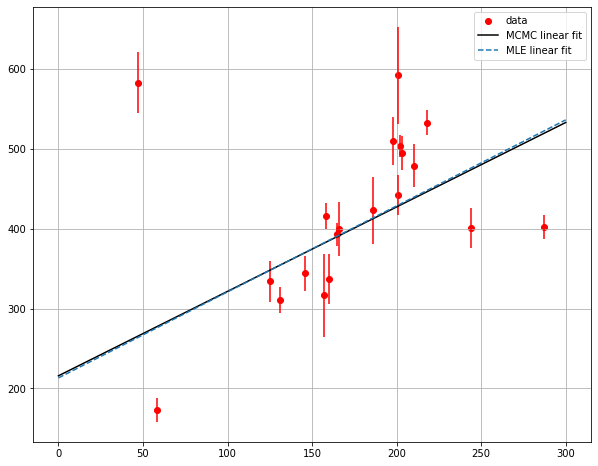

In [14]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.scatter(testdata[:,0], testdata[:,1], label='data', c='r')
plt.errorbar(testdata[:,0], testdata[:,1], yerr=testdata[:,2], fmt='none', c='r')
plt.plot(x_fit, mu, label='MCMC linear fit', c='k')
plt.plot(trange, linear(trange, *linearfit_param[0]), label='MLE linear fit', ls = '--')
plt.grid()
plt.legend()
plt.show()